# Analyze of PET models

Import methods

In [1]:
import datetime
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Matevz_arbeit\etmodul\etmodul')
sys.path
from stats import rmse, R2, MBE, nash 
from pet import penman, penman_monteith, priestley_taylor, fao_pm, \
kimberly_penman, hamon, makink, hargreaves, blaney_criddle, jensen_haise, oudin, pm_yang, fao_yang
from sklearn.linear_model import LinearRegression

### Import lysimeter data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000020739DEC898>,
      dtype=object)

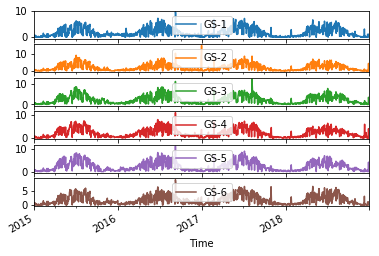

In [2]:
lysih = pd.read_csv("data\\lysimeter_et.txt", sep="\t", parse_dates=True, 
                         index_col=0, dayfirst=True)
lysid = lysih.resample("d").sum()
lysid.plot(subplots=True)

### Meteo data

Index(['wind', 'temperature', 'rh', 'pressure', 'netrad', 'soilflux',
       'Short_rad', 'refprecip'],
      dtype='object')

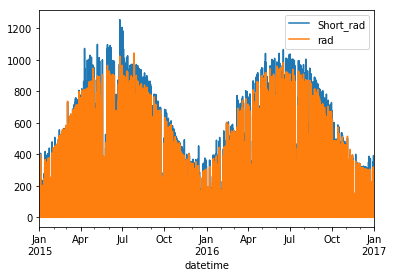

In [3]:
meteoboku = pd.read_csv("data\\meteo_hourly.txt", sep="\t", parse_dates=True, 
                         index_col=0, dayfirst=True)
radzamg = pd.read_csv("data\\radiation_ZAMG.txt", sep="\t", index_col='datetime', 
                 parse_dates={'datetime': [0,1]},dayfirst=True)*1000000/3600

meteoboku["Short_rad"]["2015-01-01 00:00:00":"2017-01-01 00:00:00"].plot()
radzamg["rad"]["2015-01-01 00:00:00":"2017-01-01 00:00:00"].plot()
plt.legend()
meteoboku.columns

In [4]:
#  Resample to hourly / prepare for PET models from 2015 till 2018
meteoboku["netrad"][meteoboku["netrad"]<0] = 0
start = "2015-01-01 00:00:00"
end = "2017-12-31 23:00:00"
meteoamean = meteoboku[:][start:end].resample("d").mean()
meteomax = meteoboku[:][start:end].resample("d").max()
meteomin = meteoboku[:][start:end].resample("d").min()
meteosum = meteoboku[:][start:end].resample("d").sum() * 0.0036

global_radh = radzamg[:][start:end].interpolate()
global_rad = global_radh.resample("d").sum() * 0.0036

meteod=pd.DataFrame(data={"tmax": meteomax["temperature"], "tmin": meteomin["temperature"],
      "rhmax": meteomax["rh"], "rhmin": meteomin["rh"], 
      "solar": global_rad["rad"], "netrad": meteosum["netrad"],
      "wind": meteoamean["wind"], "g": meteosum["soilflux"]}, index=meteomax.index)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002073C3A36D8>,
      dtype=object)

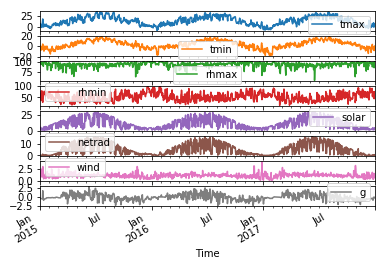

In [5]:
meteod.plot(subplots = True)

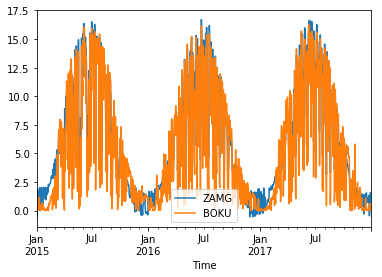

In [6]:
# Compare zamg Rn vs BOKU Rn if "netrad" from boku < 0 = 0
from inputs import Rn_calc
start = "2015-01-01 00:00:00"
end = "2017-12-31 23:00:00"
tmax = meteod["tmax"][start:end]
tmin = meteod["tmin"][start:end]
rhmax = meteod["rhmax"][start:end]
rhmin = meteod["rhmin"][start:end]
solar = meteod["solar"][start:end]
net = meteod["netrad"][start:end]
elevation = 700
latitude = 47.4920
meteoindex = meteod[start:end].index
rnzamg = Rn_calc(solar, tmax, tmin, rhmin, rhmax, elevation, latitude,
            meteoindex)
rnzamg.plot(label="ZAMG")
net.plot(label="BOKU")
plt.legend()

## Vegetation data

In [7]:
# Cuts
cuts = ("2015-05-28","2015-07-28","2015-10-13",
"2016-05-31","2016-07-26","2016-10-04",
"2017-05-30","2017-07-25","2017-10-03")

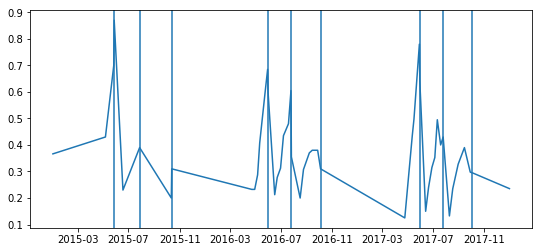

In [8]:
height = pd.read_csv("data\\height.txt", sep="\t", parse_dates=True, 
                         index_col=0, dayfirst=True)

h1=(height["MEA_Value"].resample("d").mean())/100
h=h1.interpolate()
h = h["2015-01-01 00:00:00":"2017-12-31 23:00:00"]
fig, ax=plt.subplots(figsize=(9,4))
ax.plot(h)
for c in cuts:
    ax.axvline(c, label=c)
plt.savefig('height_2015-2017.png')

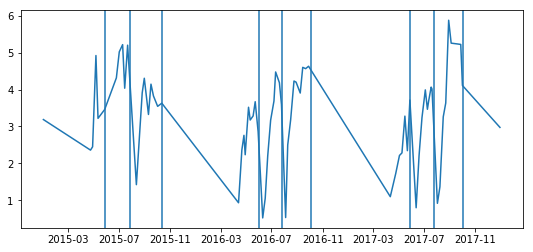

In [9]:
lail = pd.read_csv("data\\lai.txt", sep="\t", parse_dates=True, 
                         index_col=0, dayfirst=True)
lai=lail.loc[lail["id"]==9]
laid=(lai["lai"].resample("d").mean())
laid=laid.interpolate()
laid = laid["2015-01-01 00:00:00":"2017-12-31 23:00:00"]
fig, ax=plt.subplots(figsize=(9,4))
ax.plot(laid)
for c in cuts:
    ax.axvline(c)
plt.savefig('lai_2015-2017.png')

## Construct h curve

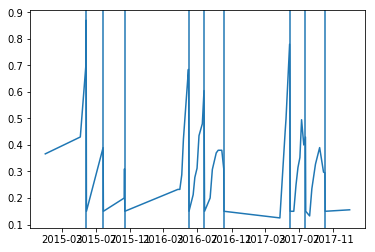

In [10]:
for cut in cuts:
    date1 = datetime.datetime.strptime(cut, "%Y-%m-%d")
    date2 = date1 + datetime.timedelta(days=1)
    h1[date2] = 0.15
h2 = h1.interpolate()
h2 = h2["2015-01-01 00:00:00":"2017-12-31 23:00:00"]
fig, ax=plt.subplots()
ax.plot(h2)
for c in cuts:
    ax.axvline(c)

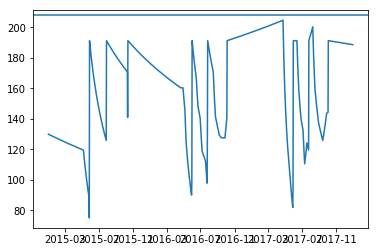

In [11]:
h=h2
ra = (np.log((2-0.67*h)/(0.123*h)))*(np.log((2-0.67*h)/(0.0123*h)))/(0.41**2)
fix, ax = plt.subplots()
ax.plot(ra)
ax.axhline(208)

## Calculate pet

In [12]:
#inputs
start = "2015-01-01 00:00:00"
stop = "2017-12-31 23:00:00"

tmax = meteod["tmax"][start:end]
tmin = meteod["tmin"][start:end]
rhmax = meteod["rhmax"][start:end]
rhmin = meteod["rhmin"][start:end]
elevation = 700
latitude = 47.4920
meteoindex = meteod[start:end].index
u2 = meteod["wind"][start:end]
net = meteod["netrad"][start:end]
solar = meteod["solar"][start:end]
hd=h[start:end]
laid=laid[start:end]
obs=pd.DataFrame(data=lysid["GS-2"], index=solar.index)

bc, days = blaney_criddle(tmin, tmax, meteoindex, latitude, k=0.75)
fao = fao_pm(tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex, u2, net=net)
har = hargreaves(meteoindex, tmax, tmin, latitude)
jh = jensen_haise(tmax, tmin, meteoindex, solar)
kp = kimberly_penman(meteoindex, tmin, tmax, rhmin, rhmax, elevation,latitude, u2, net=net)
mak = makink(solar, tmin, tmax, elevation)
pen = penman(tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex, u2,net=net)
pt = priestley_taylor(tmin, tmax, elevation, latitude, rhmin, rhmax, meteoindex, net=net)
pm = penman_monteith(u2, tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex, net=net, h=hd, lai=hd*24)
oud = oudin(tmax, tmin, meteoindex, latitude, k1=5, k2=100)
ham = hamon(tmin, tmax, meteoindex, latitude)

## Construct $k_{cb}$ curve 

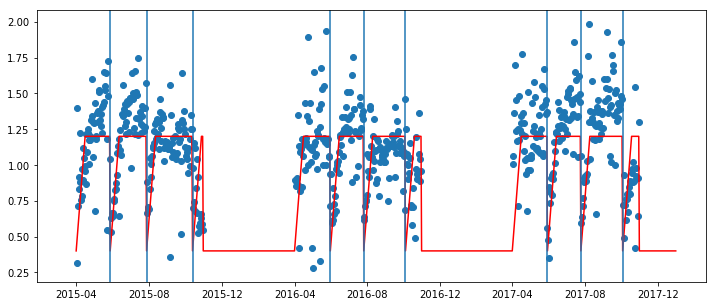

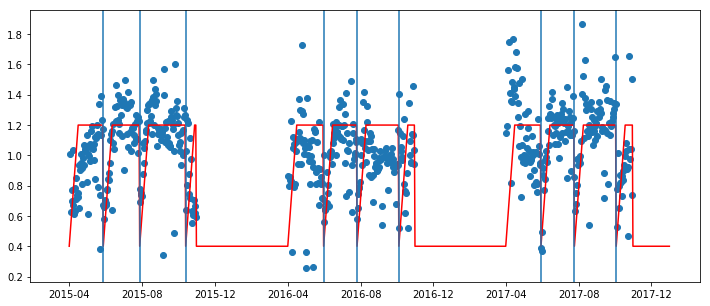

In [13]:
# kcb determination for alfalfa hay from FAO
start = "2015-01-01 00:00:00"
end = "2017-12-31 23:00:00"

kinit = 0.4
kmid = 1.2
kend=1.15
maxh=0.7

#maxroot=1-2
p=0.55
# linit... for bermuda
linit=10
ldew=15
lmid=75
llate=35

linit1=5
ldew1=20
lmid1=10
llate1=10

k=pd.DataFrame(np.nan, index=h2.index, columns=["k"])
start1 = ("2015-04-01", "2016-04-01", "2017-04-01")
nextstart = ("2016-03-31", "2017-03-31", "2018-03-31")
end1 = ("2015-10-31", "2016-10-31", "2017-10-31")
cuts1 = ("2015-05-28","2015-07-28","2015-10-13",
        "2016-05-31","2016-07-26","2016-10-04",
    "2017-05-30","2017-07-25","2017-10-03")
cut1 = ("2015-05-28","2016-05-31","2017-05-30")
cut2 = ("2015-07-28","2016-07-26", "2017-07-25")
cut3 = ("2015-10-13","2016-10-04","2017-10-03")
# Determine kinit, kmid for start of vegetation period
k=pd.DataFrame(np.nan, index=h2.index, columns=["k"])
for starts, ends in zip(start1,nextstart):
    start_1=datetime.datetime.strptime(starts, "%Y-%m-%d")
    end_1=datetime.datetime.strptime(ends, "%Y-%m-%d")
    k["k"][start_1]=kinit
    k["k"][start_1 + datetime.timedelta(days=ldew)]=kmid
    k["k"][start_1 + datetime.timedelta(days=ldew+lmid)]=kmid
    k["k"][start_1 + datetime.timedelta(days=ldew+lmid+llate)]=kend
    k["k"][start_1 + datetime.timedelta(days=ldew+lmid+llate)]=kend
    k["k"][start_1 + datetime.timedelta(days=ldew+lmid+llate+1)]=kinit
k["k"]=k["k"].interpolate()

firstcuts = (cut1, cut2, cut3)

for name in firstcuts:
    for c1, ends in zip(name, nextstart):
        c1d = datetime.datetime.strptime(c1, "%Y-%m-%d")
        c2d = datetime.datetime.strptime(ends, "%Y-%m-%d")
        k["k"][c1d:c2d]=np.nan
        k["k"][c1d] = kinit
        k["k"][c1d + datetime.timedelta(days=ldew)]=kmid
        k["k"][c1d + datetime.timedelta(days=ldew+lmid)]=kmid
        k["k"][c1d + datetime.timedelta(days=ldew+lmid+llate)]=kend
        k["k"][c1d + datetime.timedelta(days=ldew+lmid+llate)]=kend
    k["k"]=k["k"].interpolate()

for vege, vegs in zip(end1, nextstart):        
    ev = datetime.datetime.strptime(vege, "%Y-%m-%d")
    sv = datetime.datetime.strptime(vegs, "%Y-%m-%d")
    k["k"][ev:sv] = kinit
    
kl  = lysid["GS-2"][start:end]/fao[0][start:end]
kl[kl>2]=np.nan
kl[kl<0.25]=np.nan
starts = ("2015-01-01", "2015-10-31", "2016-10-31", "2017-10-31")
ends = ("2015-04-01", "2016-04-01", "2017-04-01","2017-12-31")
for s, e in zip(starts, ends):
    kl[s:e] = np.nan

fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(kl.index, kl)
ax.plot(k["k"],color="r")
for c in cuts1:
    ax.axvline(c)
#ax2 = ax.twinx()
#ax2.plot(pm[start:end])
#ax2.plot(fao[start:end])
plt.savefig('kcb_2015-2017.png')

#GS-2 vs pm
pm.columns=[0]
kl  = lysid["GS-2"][start:end]/pm[0][start:end]
kl[kl>2]=np.nan
kl[kl<0.25]=np.nan
starts = ("2015-01-01", "2015-10-31", "2016-10-31", "2017-10-31")
ends = ("2015-04-01", "2016-04-01", "2017-04-01","2017-12-31")
for s, e in zip(starts, ends):
    kl[s:e] = np.nan

fig, ax = plt.subplots(figsize=(12,5))
ax.scatter(kl.index, kl)
ax.plot(k["k"],color="r")
for c in cuts1:
    ax.axvline(c)
# GS-2 vs FAO
#kl  = lysid["GS-2"][start:end]/petk[0][start:end]
#kl[kl>2]=np.nan
#kl[kl<0.25]=np.nan
#starts = ("2015-01-01", "2015-10-31", "2016-10-31", "2017-10-31")
#ends = ("2015-04-01", "2016-04-01", "2017-04-01","2017-12-31")
#for s, e in zip(starts, ends):
#    kl[s:e] = np.nan

#fig, ax = plt.subplots(figsize=(12,5))
#ax.scatter(kl.index, kl)
#ax.plot(k["k"],color="r")
#for c in cuts1:
#    ax.axvline(c)

In [14]:
petk = fao[0]*k["k"]
petk = pd.DataFrame(index=fao.index, data=petk)

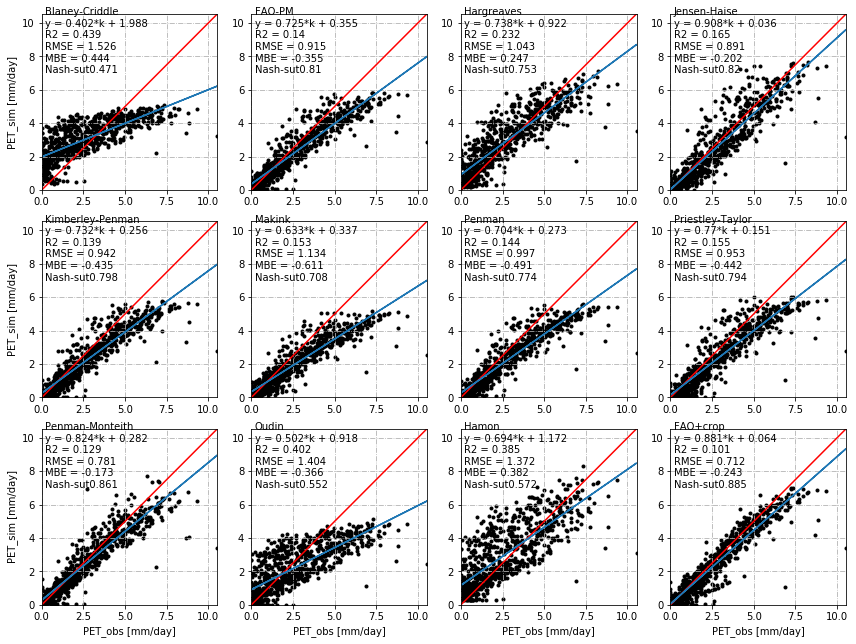

In [15]:
startp=("2015-01-01", "2015-10-31", "2016-10-31")
endp=("2015-04-01", "2016-04-01","2016-12-31")
shorts = (bc, fao, har, jh, kp, mak, pen, pt, pm, oud, ham, petk)

for start, end in zip(startp, endp):
    obs[start:end]=np.nan
    for short in shorts:
        short[start:end]=np.nan

names = ("Blaney-Criddle", "FAO-PM", "Hargreaves", "Jensen-Haise", 
         "Kimberley-Penman","Makink", "Penman", "Priestley-Taylor",
         "Penman-Monteith", "Oudin", "Hamon", "FAO+crop")
xaxis = (0,0,0,0,1,1,1,1,2,2,2,2)
yaxis = (0,1,2,3,0,1,2,3,0,1,2,3)
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(12,9))
for short, x, y, name in zip(shorts,xaxis,yaxis, names):
    compare=pd.DataFrame(data={"obs": obs["GS-2"], "sim": short[0]}, index=obs.index)
    compare=compare.dropna()
    obs1=pd.DataFrame(compare["obs"])
    sim1=pd.DataFrame(compare["sim"])
    ax[x,y].scatter(obs1, sim1, marker=".", c="k")
    ax[x,y].plot(np.arange(0,100), np.arange(0,100), c="r")
    ax[x,y].set_xlim(0, obs1.max().values)
    ax[x,y].set_ylim(0, obs1.max().values)
    ax[x,y].grid(True, linestyle="-.", alpha=1)
    if y == 0:
        ax[x,y].set_ylabel("PET_sim [mm/day]")
    if x== 2:
        ax[x,y].set_xlabel("PET_obs [mm/day]")
    model = LinearRegression(fit_intercept=True)
    x1=obs1.to_numpy()
    y1=sim1.to_numpy()
    model.fit(x1, y1)    
    ax[x,y].text(0.2, 7, name + "\n" + \
      "y = " + str(round(model.coef_[0,0],3)) + "*k + " + \
      str(round(model.intercept_[0],3)) + "\n" + \
      "R2 = "+str(round(R2(obs1.to_numpy(), sim1.to_numpy()),3)) + "\n" + \
      "RMSE = "+str(round(rmse(obs1.to_numpy(), sim1.to_numpy()),3)) + "\n" +\
      "MBE = "+str(round(MBE(obs1.to_numpy(), sim1.to_numpy()),3)) + "\n" +\
      "Nash-sut"+str(round(nash(obs1.to_numpy(), sim1.to_numpy()),3)), size = 10) 

    xfit = obs1.to_numpy()
    yfit = model.predict(xfit)
    ax[x,y].plot(xfit, yfit)
plt.savefig('default_pet.png')
plt.tight_layout()

### Effect of LAI and height data to efficiency of the model

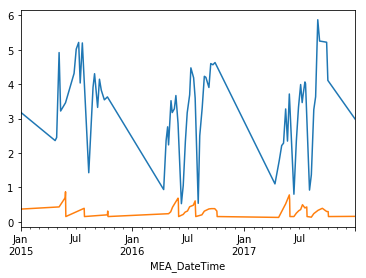

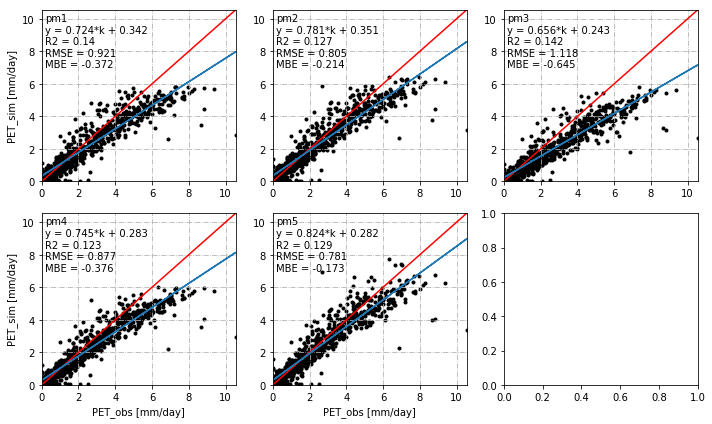

In [16]:
start = "2015-01-01 00:00:00"
end = "2017-12-31 23:00:00"
obs = obs[start:end]
tmax = meteod["tmax"][start:end]
tmin = meteod["tmin"][start:end]
rhmax = meteod["rhmax"][start:end]
rhmin = meteod["rhmin"][start:end]
elevation = 700
latitude = 47.4920
meteoindex = meteod[start:end].index
u2 = meteod["wind"][start:end]
net = meteod["netrad"][start:end]
solar = meteod["solar"][start:end]
hd=h[start:end]
laid1=laid[start:end]
laid.plot()
hd.plot()
pm1 = penman_monteith(u2, tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex, net=net)
pm2 = penman_monteith(u2, tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex, net=net, h=hd)
pm3 = penman_monteith(u2, tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex, net=net, lai=laid1)
pm4 = penman_monteith(u2, tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex, net=net, lai=hd*24)
pm5 = penman_monteith(u2, tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex, net=net, h=hd, lai=hd*24)
# ----------------------
startp=("2015-01-01", "2015-10-31", "2016-10-31")
endp=("2015-04-01", "2016-04-01","2016-12-31")
shorts = (pm1, pm2, pm3, pm4, pm5)

for start, end in zip(startp, endp):
    obs[start:end]=np.nan
    for short in shorts:
        short[start:end]=np.nan

names = ("pm1", "pm2", "pm3", "pm4", "pm5")
xaxis = (0,0,0,1,1,1)
yaxis = (0,1,2,0,1,2)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
for short, x, y, name in zip(shorts,xaxis,yaxis, names):
    compare=pd.DataFrame(data={"obs": obs["GS-2"], "sim": short[0]}, index=obs.index)
    compare=compare.dropna()
    obs1=pd.DataFrame(compare["obs"])
    sim1=pd.DataFrame(compare["sim"])
    ax[x,y].scatter(obs1, sim1, marker=".", c="k")
    ax[x,y].plot(np.arange(0,100), np.arange(0,100), c="r")
    ax[x,y].set_xlim(0, obs1.max().values)
    ax[x,y].set_ylim(0, obs1.max().values)
    ax[x,y].grid(True, linestyle="-.", alpha=1)
    if y == 0:
        ax[x,y].set_ylabel("PET_sim [mm/day]")
    if x== 1:
        ax[x,y].set_xlabel("PET_obs [mm/day]")
    model = LinearRegression(fit_intercept=True)
    x1=obs1.to_numpy()
    y1=sim1.to_numpy()
    model.fit(x1, y1)    
    ax[x,y].text(0.2, 7, name + "\n" + \
      "y = " + str(round(model.coef_[0,0],3)) + "*k + " + \
      str(round(model.intercept_[0],3)) + "\n" + \
      "R2 = "+str(round(R2(obs1.to_numpy(), sim1.to_numpy()),3)) + "\n" + \
      "RMSE = "+str(round(rmse(obs1.to_numpy(), sim1.to_numpy()),3)) + "\n" +\
      "MBE = "+str(round(MBE(obs1.to_numpy(), sim1.to_numpy()),3)), size = 10)

    xfit = obs1.to_numpy()
    yfit = model.predict(xfit)
    ax[x,y].plot(xfit, yfit)
plt.tight_layout()

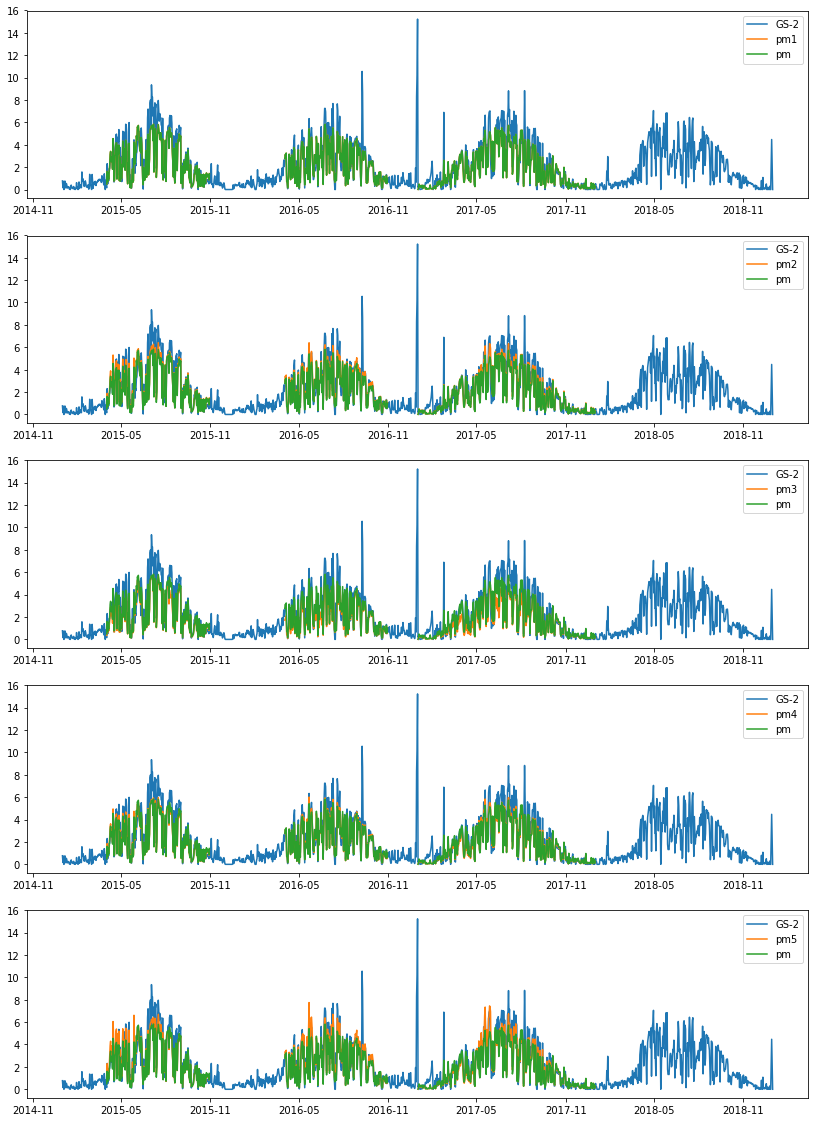

In [17]:
yaxis = (0,1,2,3,4)
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(14,20))
for short, x, y, name in zip(shorts,xaxis,yaxis, names):
    ax[y].plot(lysid["GS-2"], label="GS-2")
    ax[y].plot(short, label=name)
    ax[y].plot(pm1, label="pm")
    ax[y].legend()


## Implication of T on PET

### Overview of $CO_2$ effect at lysimeters

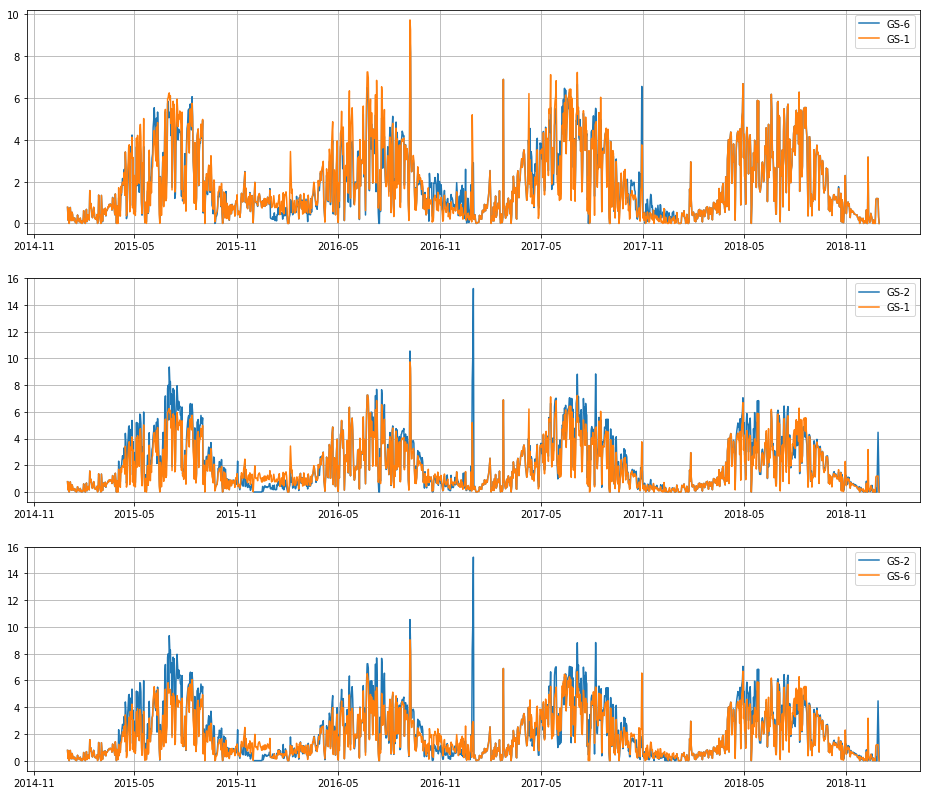

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16,14))
axes[0].plot(lysid["GS-6"])
axes[0].plot(lysid["GS-1"])
axes[1].plot(lysid["GS-2"])
axes[1].plot(lysid["GS-1"])
axes[2].plot(lysid["GS-2"])
axes[2].plot(lysid["GS-6"])
for x in (0,1,2):
    axes[x].grid()
    axes[x].legend()

### Evaluate gs

In [19]:
c=((70/55-1)/0.0009)+300
200/2.857
1/(2.4*10**(-4))

4166.666666666667

### Calculate PET with implcation of elevated $CO_2$

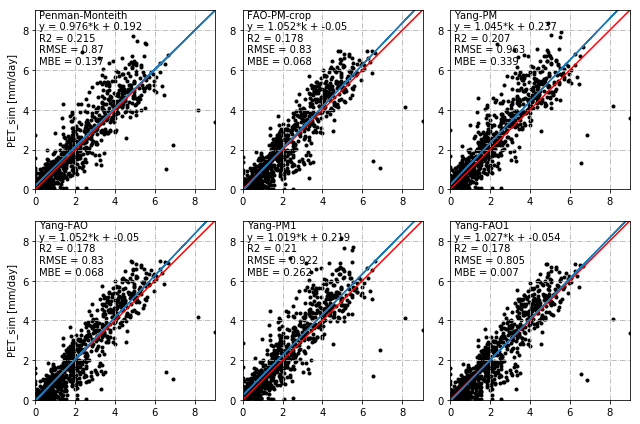

In [20]:
pm = penman_monteith(u2, tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex,h=hd, lai=hd*24, net=net)
yang_pm = pm_yang(u2, tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex, net=net,h=hd, lai=hd*24,co=603,rrs=55)
yang_pm1 = pm_yang(u2, tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex, net=net, h=hd, lai=hd*24, co=1100)
yang_fao = k["k"]*(fao_yang(tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex, u2, net=net, co=300))[0]
yang_fao = pd.DataFrame(index=fao.index, data=yang_fao)
yang_fao1 = k["k"]*(fao_yang(tmax, tmin, rhmin, rhmax, elevation, latitude, meteoindex, u2, net=net, co=600))[0]
yang_fao1 = pd.DataFrame(index=fao.index, data=yang_fao1)
obs=pd.DataFrame(data=lysid["GS-6"], index=solar.index)
#-----------------------------------------------------
startp=("2015-01-01", "2015-10-31", "2016-10-31")
endp=("2015-04-01", "2016-04-01","2016-12-31")
shorts = (pm, petk, yang_pm, yang_fao, yang_pm1, yang_fao1)

for start, end in zip(startp, endp):
    obs[start:end]=np.nan
    for short in shorts:
        short[start:end]=np.nan

names = ("Penman-Monteith", "FAO-PM-crop", "Yang-PM", "Yang-FAO", "Yang-PM1", "Yang-FAO1")
xaxis = (0,0,0,1,1,1)
yaxis = (0,1,2,0,1,2)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9,6))
for short, x, y, name in zip(shorts,xaxis,yaxis, names):
    compare=pd.DataFrame(data={"obs": obs["GS-6"], "sim": short[0]}, index=obs.index)
    compare=compare.dropna()
    obs1=pd.DataFrame(compare["obs"])
    sim1=pd.DataFrame(compare["sim"])
    ax[x,y].scatter(obs1, sim1, marker=".", c="k")
    ax[x,y].plot(np.arange(0,100), np.arange(0,100), c="r")
    ax[x,y].set_xlim(0, obs1.max().values)
    ax[x,y].set_ylim(0, obs1.max().values)
    ax[x,y].grid(True, linestyle="-.", alpha=1)
    if y == 0:
        ax[x,y].set_ylabel("PET_sim [mm/day]")
    if x== 2:
        ax[x,y].set_xlabel("PET_obs [mm/day]")
    model = LinearRegression(fit_intercept=True)
    x1=obs1.to_numpy()
    y1=sim1.to_numpy()
    model.fit(x1, y1)    
    ax[x,y].text(0.2, 6.3, name + "\n" + \
      "y = " + str(round(model.coef_[0,0],3)) + "*k + " + \
      str(round(model.intercept_[0],3)) + "\n" + \
      "R2 = "+str(round(R2(obs1.to_numpy(), sim1.to_numpy()),3)) + "\n" + \
      "RMSE = "+str(round(rmse(obs1.to_numpy(), sim1.to_numpy()),3)) + "\n" +\
      "MBE = "+str(round(MBE(obs1.to_numpy(), sim1.to_numpy()),3)), size = 10)

    xfit = obs1.to_numpy()
    yfit = model.predict(xfit)
    ax[x,y].plot(xfit, yfit)
plt.tight_layout()

# Calibration